# Generating trading signals with Linear Regression and Gradient Boosting

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import sys, os
from time import time
from collections import defaultdict
from itertools import product

import numpy as np
import pandas as pd
import statsmodels.api as sm

import lightgbm as lgb

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import spearmanr

from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.utils import get_clean_factor_and_forward_returns

import matplotlib.pyplot as plt
import seaborn as sns

## Settings

In [3]:
sns.set_style('whitegrid')

In [4]:
np.random.seed(42)

In [5]:
idx = pd.IndexSlice

In [6]:
YEAR = 252 # days
MONTH = 21 # days

In [7]:
def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}'

## Get Data

In [8]:
DATA_PATH = Path('..', 'data')

In [9]:
data = (pd.read_hdf(DATA_PATH / 'stock_prices.h5', 'model_data')
        .sort_index())

In [10]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1402295 entries, ('A', Timestamp('2006-01-03 00:00:00')) to ('ZMH', Timestamp('2015-07-02 00:00:00'))
Data columns (total 48 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   ret_01       1401795 non-null  float64
 1   ret_03       1400795 non-null  float64
 2   ret_05       1399795 non-null  float64
 3   ret_10       1397295 non-null  float64
 4   ret_21       1391795 non-null  float64
 5   ret_42       1381295 non-null  float64
 6   ret_63       1370795 non-null  float64
 7   ret_126      1339295 non-null  float64
 8   ret_252      1276295 non-null  float64
 9   ret_fwd      1402295 non-null  float64
 10  BB_UP        1392795 non-null  float64
 11  BB_LOW       1392795 non-null  float64
 12  BB_SQUEEZE   1392795 non-null  float64
 13  HT           1370795 non-null  float64
 14  SAR          1401795 non-null  float64
 15  ADX          1388795 non-null  float64
 16  ADXR         13822

To facilitate model formulation, we assign target, features, and categorical variables.

In [11]:
target = 'ret_fwd'
features = data.columns.drop(target)

In [12]:
categoricals = ['month', 'weekday']

## Custom Time Series Cross-Validation

In [13]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits


## Model Selection: Lookback, lookahead and roll-forward periods

We'll use five years of training data to predict the 1-day forward returns for the following three months for all models.

In [14]:
train_length = 5 * YEAR
test_length = 3 * MONTH

In [15]:
lookahead = 1

We'll create 16 quarters worth of out-of-sample predictions so we can select the past 4 quarters to select a model for a subsequent quarter with three years total of out-of-sample forecasts.

In [16]:
n_splits = 16

In [17]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_length,
                          lookahead=lookahead,
                          train_period_length=train_length)

Show rolling cross-validation periods - note that the folds move backwards in time:

In [18]:
for n_split, (train_idx, test_idx) in enumerate(cv.split(X=data)):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    
    train_days = train.groupby(level="ticker").size().value_counts().index[0]
    train_start, train_end = train_dates.min().date(), train_dates.max().date()
    
    test_days = test.groupby(level="ticker").size().value_counts().index[0]
    test_start, test_end = test_dates.min().date(), test_dates.max().date()
                                                  
    print(f'Split: {n_split:02} | # Train: {train_start} - {train_end} ({train_days:5,.0f} days) | '
          f'Test: {test_start} - {test_end} ({test_days} days)')

Split: 00 | # Train: 2011-11-08 - 2016-09-29 (1,260 days) | Test: 2016-09-30 - 2016-12-29 (63 days)
Split: 01 | # Train: 2011-08-11 - 2016-06-30 (1,260 days) | Test: 2016-07-01 - 2016-09-29 (63 days)
Split: 02 | # Train: 2011-05-16 - 2016-04-01 (1,260 days) | Test: 2016-04-04 - 2016-06-30 (63 days)
Split: 03 | # Train: 2011-02-14 - 2015-12-30 (1,260 days) | Test: 2015-12-31 - 2016-04-01 (63 days)
Split: 04 | # Train: 2010-11-17 - 2015-09-30 (1,260 days) | Test: 2015-10-01 - 2015-12-30 (63 days)
Split: 05 | # Train: 2010-08-20 - 2015-07-01 (1,260 days) | Test: 2015-07-02 - 2015-09-30 (63 days)
Split: 06 | # Train: 2010-05-25 - 2015-04-01 (1,260 days) | Test: 2015-04-02 - 2015-07-01 (63 days)
Split: 07 | # Train: 2010-02-25 - 2014-12-30 (1,260 days) | Test: 2014-12-31 - 2015-04-01 (63 days)
Split: 08 | # Train: 2009-11-26 - 2014-09-30 (1,260 days) | Test: 2014-10-01 - 2014-12-30 (63 days)
Split: 09 | # Train: 2009-08-31 - 2014-07-03 (1,260 days) | Test: 2014-07-04 - 2014-09-30 (63 days)


## Baseline: Linear Regression

### One-hot encoding

In [19]:
df = (pd.get_dummies(data, columns=categoricals, drop_first=True)
      .dropna()
      .sort_index())

X = df.drop(target, axis=1)
y = df[target]

### Run cross-validation

Instantiate a `LinearRegression` object

In [20]:
lr = LinearRegression()

Train and predict for each fold, capturing the predictions.

In [21]:
%%time
lr_preds = []
for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    lr_preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
lr_preds = pd.concat(lr_preds)

CPU times: user 3min 5s, sys: 2.88 s, total: 3min 8s
Wall time: 27.6 s


In [22]:
lr_preds.to_hdf(DATA_PATH / 'predictions.h5', 'linear_regression')

### Evaluate Predictions using the Information Coefficient

Across all sample days, the IC is around 2.67.

In [23]:
lr_ic, p = spearmanr(lr_preds.y_true, lr_preds.y_pred)
f'{lr_ic:.4f} ({p:.2%})'

'0.0249 (0.00%)'

On a daily basis - which is more relevant because we will be trading on the predictions for a given day - the IC has a mean of 1.1 and a median of 1.03.

In [24]:
daily_ic_lr = lr_preds.groupby(level='date').apply(lambda x: spearmanr(x.y_true, x.y_pred)[0])

In [25]:
f'Daily IC - Mean: {daily_ic_lr.mean():.4f} | CV: {daily_ic_lr.std()/daily_ic_lr.mean():.2f}'

'Daily IC - Mean: 0.0061 | CV: 24.11'

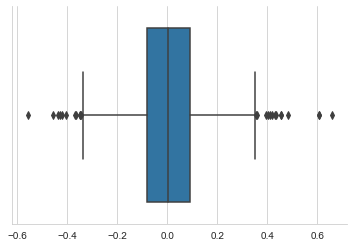

In [26]:
sns.boxplot(daily_ic_lr)
sns.despine();

## Regularized Linear Regression

We define a range of `alpha` penalty values (see [docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html))

In [27]:
ridge_alphas = np.logspace(-5, 15, 21)[::2]

In [28]:
ridge_alphas

array([1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05, 1.e+07, 1.e+09,
       1.e+11, 1.e+13, 1.e+15])

### Ridge Regression

The hyperparameter `alpha` implies an additional inner for loop that generates predictions for each fold and `alpha` value:

In [29]:
%%time
ridge_preds = []
scaler = MinMaxScaler()
for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
    print(f'{i}', end=' ', flush=True)
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_train = scaler.fit_transform(X_train)
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    X_test = scaler.transform(X_test)
    cv_predictions = []
    for alpha in ridge_alphas:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train, y_train)
        y_pred = ridge.predict(X_test)
        cv_predictions.append(pd.DataFrame({alpha: y_pred},
                                           index=y_test.index))
    ridge_preds.append(pd.concat(cv_predictions, axis=1).assign(y_test=y_test))
ridge_preds = pd.concat(ridge_preds)
print()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
CPU times: user 4min 39s, sys: 11.1 s, total: 4min 50s
Wall time: 41.2 s


#### Evaluate Predictions

In [30]:
ic_by_day_ridge = {}
for alpha in ridge_alphas:
    ic_by_day_ridge[alpha] = (ridge_preds.groupby(level='date')
                              .apply(lambda x: spearmanr(x[alpha], x.y_test)[0])
                              .mean())

In [31]:
best_alpha_ridge = pd.Series(ic_by_day_ridge).idxmax()

In [32]:
best_ic_by_day_ridge = (ridge_preds.groupby(level='date')
                        .apply(lambda x: spearmanr(x[best_alpha_ridge], x.y_test)[0]))

In [33]:
print(f'Daily IC - Mean: {best_ic_by_day_ridge.mean():.4f} | '
      f'CV: {best_ic_by_day_ridge.std()/best_ic_by_day_ridge.mean():.2f}')

Daily IC - Mean: 0.0125 | CV: 11.62


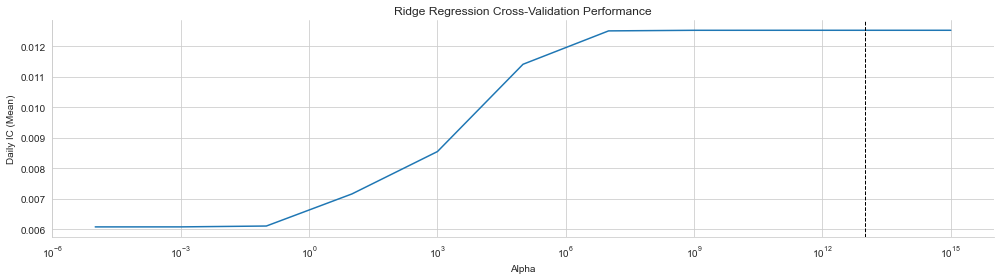

In [34]:
ax = pd.Series(ic_by_day_ridge).plot(figsize=(14, 4),
                                  logx=True, 
                                  title='Ridge Regression Cross-Validation Performance')
ax.axvline(best_alpha_ridge, c='k', ls='--', lw=1)
ax.set_ylabel('Daily IC (Mean)')
ax.set_xlabel('Alpha')
sns.despine()
plt.tight_layout();

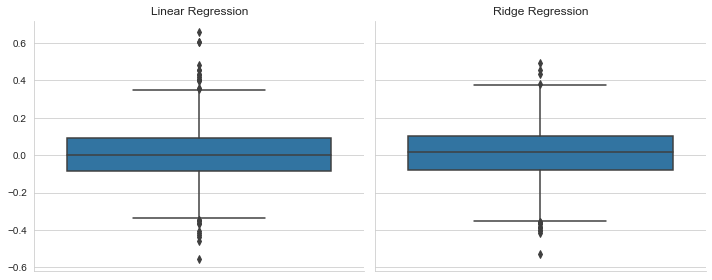

In [35]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

sns.boxplot(daily_ic_lr, ax=axes[0], orient='v')
axes[0].set_title('Linear Regression')

ridge_daily_ic = ridge_preds.groupby(level='date').apply(lambda x: spearmanr(x[best_alpha_ridge], x.y_test)[0])
sns.boxplot(ridge_daily_ic, ax=axes[1], orient='v')
axes[0].set_title('Linear Regression')
axes[1].set_title('Ridge Regression')
sns.despine()
fig.tight_layout();

In [36]:
ridge_preds[best_alpha_ridge].to_hdf(DATA_PATH / 'predictions.h5', 'ridge_regression')

### Lasso Regression

In [ ]:
lasso_alphas = np.logspace(-15, -5, 11)

In [ ]:
lasso_preds = []
scaler = MinMaxScaler()
for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
    print(f'\nFold {i}')
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    X_train = scaler.fit_transform(X_train)
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    X_test = scaler.transform(X_test)    
    cv_predictions = []
    for alpha in lasso_alphas:
        print(f'{alpha:.0e}', end=' ', flush=True)
        lasso = Lasso(alpha=alpha)
        lasso.fit(X_train, y_train)
        y_pred = lasso.predict(X_test)
        cv_predictions.append(pd.DataFrame({alpha: y_pred},
                                           index=y_test.index))
    lasso_preds.append(pd.concat(cv_predictions, axis=1).assign(y_test=y_test))
lasso_preds = pd.concat(lasso_preds)

#### Evaluate Predictions

In [ ]:
ic_by_day_lasso = {}
for alpha in lasso_alphas:
    ic_by_day_lasso[alpha] = (lasso_preds.groupby(level='date')
                              .apply(lambda x: spearmanr(x[alpha], x.y_test)[0]).mean())

In [ ]:
pd.Series(ic_by_day_lasso)

In [ ]:
ax = pd.Series(ic_by_day_lasso).plot(figsize=(14, 4),
                                  logx=True, 
                                  title='Lasso Regression Cross-Validation Performance')
ax.axvline(pd.Series(ic_by_day_lasso).idxmax(), c='k', ls='--', lw=1)
ax.set_ylabel('Daily IC (Mean)')
ax.set_xlabel('Alpha')
sns.despine()
plt.tight_layout();

## LightGBM Model Tuning

In [37]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

### Hyperparameter Options

In [38]:
base_params = dict(boosting='gbdt',
                   objective='regression',
                   metric='None',
                   device='gpu', # uncomment to use gpu
                   max_bin=63,   # uncomment to use gpu
                   verbose=-1)

Here are some reasonable hyperparameter choices; feel free to experiment!

In [39]:
learning_rate_ops = [.01]
max_depths = [5, 6, 7]
# we'll set the num_leave parameter to enable leaf-wise growth
num_leaves_opts = [2 ** i for i in max_depths]
feature_fraction_opts = [.6, .95]
min_data_in_leaf_opts = [250, 750, 1500]

In [40]:
param_names = ['learning_rate', 
               'num_leaves',
               'feature_fraction', 
               'min_data_in_leaf']

In [41]:
cv_params = list(product(learning_rate_ops,
                         num_leaves_opts,
                         feature_fraction_opts,
                         min_data_in_leaf_opts))
n_params = len(cv_params)
print(f'# Parameters: {n_params}')

# Parameters: 18


In [42]:
# randomly sample cv param combinations, here: 50%
cvp = np.random.choice(list(range(n_params)),
                       size=int(n_params / 1),
                       replace=False)
cv_params_ = [cv_params[i] for i in cvp]

To identify the ideal number of iterations across folds, we generate predictions for a range of iterations.

In [43]:
num_boost_rounds = [10, 25, 50, 75, 100, 150, 200] + list(range(250, 5001, 250))

### Run Cross-Validation

With this setup, we'll train 18 different models for 16 folds each, using the past five years to predict the next three months.

In [44]:
print(f'Train: {train_length:3.0f} | '
      f'Test: {test_length:2.0f} | '
      f'Folds: {n_splits:.0f} | '
      f'Params: {len(cv_params_):3.0f}')

Train: 1260 | Test: 63 | Folds: 16 | Params:  18


In [45]:
lgb_store = 'lgb_tuning.h5'

In [46]:
model_path = Path('models')
if not model_path.exists():
    model_path.mkdir()

Ready to go: for each fold, we'll plot the best iteration and the corresponding avg. daily IC and its coefficient of variation as well as the time per iteration.

In [49]:
T = 0
for p, param_vals in enumerate(cv_params_):

    key = '/'.join([str(p) for p in param_vals])
    model_key = '_'.join(key.split('/'))
    params = dict(zip(param_names, param_vals))
    params.update(base_params)
    start = time()

    # create data structures to store results
    daily_ic_mean = np.full(shape=(len(num_boost_rounds),
                                   n_splits),
                            fill_value=np.nan)
    daily_ic_std = daily_ic_mean.copy()

    # train on data through 2016 to select the best model
    for n_split, (train_idx, test_idx) in enumerate(cv.split(X=data)):
        print(f'{n_split:2.0f} |', end=' ', flush=True)
        iteration = time()

        # select data points and create binary train set
        train_set = data.iloc[train_idx, :]
        lgb_train = lgb.Dataset(data=train_set.loc[:, features],
                                label=train_set[target],
                                categorical_feature=categoricals,
                                free_raw_data=False)

        # create test data
        test_set = data.iloc[test_idx, :]
        X_test = test_set.loc[:, features]
        y_test = test_set.loc[:, target].to_frame('y_true')
        
        # train model for max num_boost_rounds
        model = lgb.train(params=params,
                          train_set=lgb_train,
                          num_boost_round=num_boost_rounds[-1],
                          verbose_eval=False)
        
        # persist model to generate out-of-sample predictions
        model_file = model_path / f'{model_key}_{n_split}.txt'
        model.save_model(model_file.as_posix())
        
        # evaluate trained model for various num_boost_rounds
        for i, num_boost_round in enumerate(num_boost_rounds):
            y_pred = model.predict(X_test, num_iteration=num_boost_round)
            y_test = y_test.assign(y_pred=y_pred)
            
            # compute daily information coefficient
            daily_ic = (y_test.groupby(level='date')
                        .apply(lambda x: spearmanr(x.y_true, x.y_pred)[0]))

            daily_ic_mean[i, n_split] = daily_ic.mean()
            daily_ic_std[i, n_split] = daily_ic.std()

        mu = pd.Series(daily_ic_mean[:, n_split], index=num_boost_rounds)
        s = pd.Series(daily_ic_std[:, n_split], index=num_boost_rounds)
        msg = f'{mu.idxmax():6,.0f} | {mu.max():6.2%} | {s[mu.idxmax()]/mu.max():6.1f} | '
        print(msg + f'{time() - iteration:5.1f}', flush=True)

    t = time() - start
    T += t
    
    ic = pd.DataFrame(daily_ic_mean, index=num_boost_rounds)
    ic_mean = ic.mean(1).max()
    ic_mean_n = ic.mean(1).idxmax()

    print(f'\n{p:3.0f} | {format_time(T)} | {format_time(t)} | {params["learning_rate"]:5.2f} | '
          f'{params["num_leaves"]:3.0f} | {params["feature_fraction"]:3.0%} | '
          f'{params["min_data_in_leaf"]:4.0f} | '
          f' {ic_mean:6.2%} | {ic_mean_n:5.0f}')
    
    ic.to_hdf(lgb_store, 'ic/' + key)

 0 |     10 |  1.37% |    9.1 |  16.4
 1 |  5,000 | -0.28% |  -50.7 |  47.5
 2 |    200 |  1.24% |   15.0 |  47.7
 3 |  3,000 |  4.43% |    4.8 |  56.2
 4 |     50 |  3.99% |    3.5 | 116.8
 5 |    750 |  3.40% |    4.6 | 110.5
 6 |    750 |  1.88% |    6.7 |  86.0
 7 |    750 |  2.50% |    6.5 |  61.1
 8 |  4,750 |  3.37% |    5.2 |  65.3
 9 |    100 |  1.40% |    7.0 |  60.6
10 |     10 |  1.66% |    6.4 |  59.5
11 |  4,250 |  3.52% |    2.9 |  60.3
12 |  4,750 |  2.38% |    3.6 |  57.2
13 |     10 |  2.25% |    3.3 |  54.2
14 |    500 |  3.37% |    3.2 |  54.8
15 |  4,000 | -0.92% |  -11.2 |  51.1

  0 | 00:16:46 | 00:16:46 |  0.01 |  32 | 60% |  250 |   1.58% |  4000
 0 |  3,000 |  1.74% |    8.7 |  52.0
 1 |  4,750 | -0.04% | -386.8 |  53.0
 2 |    500 |  0.81% |   25.5 |  57.5
 3 |  4,250 |  4.11% |    5.1 |  57.1
 4 |    750 |  4.06% |    3.6 |  56.2
 5 |    750 |  4.06% |    3.5 |  57.3
 6 |    750 |  1.64% |    7.4 |  54.9
 7 |  2,750 |  2.63% |    5.4 |  54.4
 8 |  2,500 |  3

 1 |  5,000 |  0.76% |   18.9 |  59.3
 2 |     10 |  2.88% |    5.3 |  55.9
 3 |  1,750 |  3.40% |    6.1 |  56.2
 4 |    500 |  4.03% |    3.7 |  55.4
 5 |    500 |  3.35% |    4.2 |  55.9
 6 |  1,000 |  1.47% |    7.6 |  55.4
 7 |  2,500 |  2.66% |    5.5 |  57.3
 8 |     10 |  3.40% |    5.8 |  56.0
 9 |    100 |  2.25% |    3.8 |  55.3
10 |     75 |  3.01% |    4.3 |  55.6
11 |  5,000 |  3.83% |    2.6 |  56.9
12 |  3,750 |  2.55% |    3.3 |  56.1
13 |     50 |  1.93% |    3.8 |  55.4
14 |     25 |  4.46% |    2.1 |  55.5
15 |  5,000 | -0.90% |  -11.0 |  55.8

 12 | 05:32:10 | 00:15:00 |  0.01 |  32 | 95% |  750 |   1.45% |  1000
 0 |  3,250 |  1.50% |    9.4 | 112.4
 1 |  5,000 |  0.81% |   17.2 | 112.0
 2 |  5,000 |  1.28% |   15.3 | 111.9
 3 |  1,500 |  4.58% |    4.5 | 115.2
 4 |    750 |  4.21% |    3.5 | 113.6
 5 |    200 |  3.99% |    3.8 | 114.8
 6 |    500 |  2.43% |    5.1 | 115.9
 7 |    250 |  3.21% |    5.1 | 116.0
 8 |  5,000 |  4.51% |    3.7 | 117.6
 9 |     25 |  1

### Collect Results

Here we gather the daily IC values for the various models alongside the matching hyperparameters.

In [50]:
id_vars = ['num_iteration', 'learning_rate', 'num_leaves', 'feature_frac', 'num_data']

In [51]:
results = []
with pd.HDFStore('lgb_tuning.h5') as store:
    for k in [k[1:] for k in store.keys() if k[1:].startswith('ic/')]:
        _, lr, num_leaves, feature_frac, num_data = k.split('/')
        results.append(store[k].assign(learning_rate=float(lr),
                                       num_leaves=int(num_leaves),
                                       feature_frac=float(feature_frac),
                                       num_data=int(num_data)))

In [52]:
results = pd.concat(results).reset_index().rename(columns={'index': 'num_iteration'})
results = pd.melt(results,
                  id_vars=id_vars,
                  value_name='ic',
                  var_name='fold').apply(pd.to_numeric)

In [53]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7776 entries, 0 to 7775
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_iteration  7776 non-null   int64  
 1   learning_rate  7776 non-null   float64
 2   num_leaves     7776 non-null   int64  
 3   feature_frac   7776 non-null   float64
 4   num_data       7776 non-null   int64  
 5   fold           7776 non-null   int64  
 6   ic             7776 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 425.4 KB


In [54]:
results.head()

,num_iteration,learning_rate,num_leaves,feature_frac,num_data,fold,ic
0,10,0.01,64,0.95,1500,0,-0.005167
1,25,0.01,64,0.95,1500,0,-0.016321
2,50,0.01,64,0.95,1500,0,-0.015368
3,75,0.01,64,0.95,1500,0,-0.015796
4,100,0.01,64,0.95,1500,0,-0.008647


## Generate Predictions for best models

Now we'll select the parameters that produced the 10 best daily IC values over four consecutive quarters and generate predictions for these configurations for the following quarter, using the already trained model.

In [55]:
param_names = id_vars[1:]

In [56]:
predictions = []
for fold, (train_idx, test_idx) in enumerate(cv.split(X=data)):
    if fold >= 12:
        break
    print(fold, end=' ', flush=True)
    
    # get test features and outcomes
    test_data = data.iloc[test_idx]
    X_test = test_data.loc[:, features]
    fold_predictions = test_data.loc[:, target].to_frame('y_true')

    # select top 10 models based on prior 12 months performance
    best_params = (results[results.fold.isin(list(range(fold + 1, fold + 4)))]
                   .groupby(id_vars)
                   .ic.mean()
                   .nlargest(n=10).to_frame('ic'))
    
    # generate predictions for top 10 models
    for pos, params in enumerate(best_params.reset_index().to_dict('records')):
        num_iteration = params['num_iteration']
        param_vals = [params[p] for p in param_names]
        model_key = '_'.join([str(p) for p in param_vals])
        params = dict(zip(param_names, param_vals))
        params.update(base_params)

        # select matching model for current quarter
        model_path = Path('models/' + model_key + f'_{fold}.txt')
        model = lgb.Booster(model_file=model_path.as_posix())
        
        # predict returns based on current quarter features
        fold_predictions[pos] = model.predict(X_test.loc[:, model.feature_name()], 
                                              num_iteration=num_iteration)
    predictions.append(fold_predictions)
predictions = pd.concat(predictions)    

0 1 2 3 4 5 6 7 8 9 10 11 

In [57]:
predictions.sort_index().info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 366259 entries, ('A', Timestamp('2014-01-09 00:00:00')) to ('ZMH', Timestamp('2015-07-02 00:00:00'))
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   y_true  366259 non-null  float64
 1   0       366259 non-null  float64
 2   1       366259 non-null  float64
 3   2       366259 non-null  float64
 4   3       366259 non-null  float64
 5   4       366259 non-null  float64
 6   5       366259 non-null  float64
 7   6       366259 non-null  float64
 8   7       366259 non-null  float64
 9   8       366259 non-null  float64
 10  9       366259 non-null  float64
dtypes: float64(11)
memory usage: 32.1+ MB


In [58]:
pred_cols = predictions.columns.drop('y_true')
for col in pred_cols:
    rho, p = spearmanr(predictions.y_true, predictions[col])
    print(f'Top {col}: {rho * 100:.2f} ({p:.2%})')

Top 0: 2.59 (0.00%)
Top 1: 2.91 (0.00%)
Top 2: 2.12 (0.00%)
Top 3: 3.15 (0.00%)
Top 4: 3.47 (0.00%)
Top 5: 3.06 (0.00%)
Top 6: 3.14 (0.00%)
Top 7: 2.56 (0.00%)
Top 8: 2.94 (0.00%)
Top 9: 2.29 (0.00%)


Let's compare the performance of individual models to that of an averaged ensemble:

In [59]:
rho, p = spearmanr(predictions.y_true, predictions.loc[:, pred_cols].mean(1))
print(f'\nAvg: {rho * 100:.2f} ({p:.2%})')


Avg: 3.01 (0.00%)


In [60]:
with pd.HDFStore(DATA_PATH / 'predictions.h5') as store:
    store.put(f'gradient_boosting', predictions.loc[:, pred_cols].mean(1))

## AlphaLens Analysis

Let's take a look how the model predictions perform from an alpha factor perspective.

### Prepare Factor Data

In [61]:
t = 1
idx = pd.IndexSlice
factor = (predictions.loc[:, pred_cols].mean(1)
          .sort_index()
          .dropna()
          .tz_localize('UTC', level='date')
          .swaplevel())

In [62]:
factor.head()

date                       ticker
2014-01-09 00:00:00+00:00  A         0.001209
2014-01-10 00:00:00+00:00  A         0.001213
2014-01-13 00:00:00+00:00  A         0.001211
2014-01-14 00:00:00+00:00  A         0.001174
2014-01-15 00:00:00+00:00  A         0.001138
dtype: float64

In [63]:
dates = factor.index.unique('date')
dates.min(), dates.max()

(Timestamp('2014-01-09 00:00:00+0000', tz='UTC'),
 Timestamp('2016-12-29 00:00:00+0000', tz='UTC'))

In [64]:
tickers = factor.index.unique('ticker')

### Select next available trade prices

Using next available prices.

In [65]:
def get_trade_prices(tickers):
    return (pd.read_hdf(DATA_PATH / 'stock_prices.h5', 'us_stocks')
              .loc[idx[tickers, '2006':'2017'], 'open']
              .unstack('ticker')
              .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [66]:
trade_prices = get_trade_prices(tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3020 entries, 2006-01-03 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 500 entries, A to ZMH
dtypes: float64(500)
memory usage: 11.5 MB


### Get AlphaLens Inputs

In [67]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=10,
                                                   periods=(1, 2, 3, 5))
factor_data.sort_index().info()

Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 363260 entries, (Timestamp('2014-01-09 00:00:00+0000', tz='UTC'), 'A') to (Timestamp('2016-12-29 00:00:00+0000', tz='UTC'), 'ZION')
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   1D               363260 non-null  float64
 1   2D               363260 non-null  float64
 2   3D               363260 non-null  float64
 3   5D               363260 non-null  float64
 4   factor           363260 non-null  float64
 5   factor_quantile  363260 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 18.0+ MB


### Summary Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.045424,0.003454,-0.002372,0.003829,36697,10.102131
2,-0.015570,0.004427,-0.000718,0.002200,36331,10.001376
3,-0.011479,0.005109,-0.000198,0.001831,36143,9.949623
4,-0.009567,0.005765,0.000148,0.001649,36396,10.019270
5,-0.008501,0.006417,0.000435,0.001556,36269,9.984309
6,-0.007557,0.008862,0.000704,0.001541,36171,9.957331
7,-0.006271,0.012502,0.000990,0.001604,36209,9.967792
8,-0.005156,0.016861,0.001339,0.001745,36299,9.992567
9,-0.003432,0.021773,0.001874,0.002061,36140,9.948797


Returns Analysis


,1D,2D,3D,5D
Ann. alpha,0.086,0.018,-0.022,-0.012
beta,0.037,0.084,0.084,0.088
Mean Period Wise Return Top Quantile (bps),2.087,-0.308,-1.737,-1.994
Mean Period Wise Return Bottom Quantile (bps),-7.557,-4.250,-2.166,-2.502
Mean Period Wise Spread (bps),9.644,3.912,0.407,0.474


Information Analysis


,1D,2D,3D,5D
IC Mean,0.010,0.006,0.000,0.001
IC Std.,0.153,0.155,0.161,0.160
Risk-Adjusted IC,0.068,0.040,0.002,0.008
t-stat(IC),1.867,1.089,0.058,0.216
p-value(IC),0.062,0.276,0.953,0.829
IC Skew,0.112,0.128,0.254,0.280
IC Kurtosis,0.759,0.692,0.792,0.737


Turnover Analysis


,1D,2D,3D,5D
Quantile 1 Mean Turnover,0.661,0.715,0.737,0.700
Quantile 2 Mean Turnover,0.820,0.836,0.846,0.833
Quantile 3 Mean Turnover,0.850,0.856,0.862,0.855
Quantile 4 Mean Turnover,0.859,0.866,0.870,0.867
Quantile 5 Mean Turnover,0.861,0.869,0.872,0.867
Quantile 6 Mean Turnover,0.861,0.866,0.868,0.867
Quantile 7 Mean Turnover,0.852,0.864,0.866,0.864
Quantile 8 Mean Turnover,0.839,0.854,0.861,0.855
Quantile 9 Mean Turnover,0.801,0.822,0.834,0.826
Quantile 10 Mean Turnover,0.617,0.654,0.683,0.671


,1D,2D,3D,5D
Mean Factor Rank Autocorrelation,0.375,0.312,0.266,0.316


<Figure size 432x288 with 0 Axes>

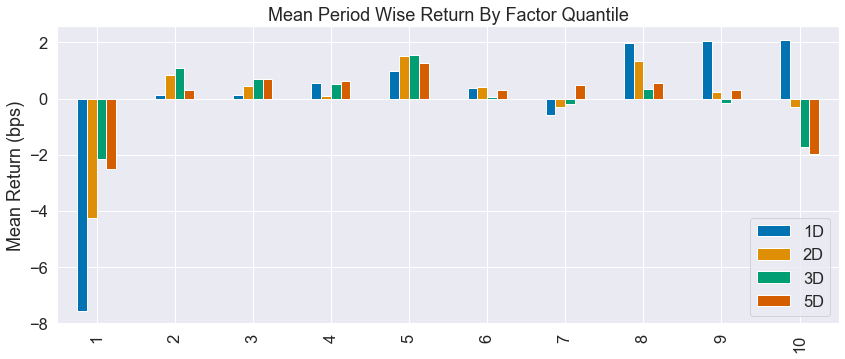

In [68]:
create_summary_tear_sheet(factor_data)